## Amazon Reviews
Use one of the following datasets to perform sentiment analysis on the given Amazon reviews. Pick one of the "small" datasets that is a reasonable size for your computer. The goal is to create a model to algorithmically predict if a review is positive or negative just based on its text. Try to see how these reviews compare across categories. Does a review classification model for one category work for another?

# $$Sports\ and\ Outdoors\ Reviews$$


## Import Libraries

In [1]:
import gzip
import itertools
import string
import wordcloud
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pylab as pl

from collections import Counter
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

%matplotlib inline

---
# Part I EDA and Preprocessing
---
### `Download and Unzip Reviews into Pandas DataFrame`

In [2]:
# Code provided via http://jmcauley.ucsd.edu/data/amazon/

def parse_gz(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def convert_to_DF(path):
    i = 0
    df = {}
    for d in parse_gz(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

* Convert compressed file of data into Pandas DataFrame

In [7]:
sports_outdoors = convert_to_DF('reviews_Sports_and_Outdoors_5.json.gz')

In [8]:
print('Dataset size: {:,} words'.format(len(sports_outdoors)))

Dataset size: 296,337 words


In [9]:
sports_outdoors.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5.0,Woks very good,1390694400,"01 26, 2014"
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5.0,Works as well as the factory tool,1328140800,"02 2, 2012"
2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]",If you don't have a 3/32 punch or would like t...,4.0,"It's a punch, that's all.",1330387200,"02 28, 2012"
3,A148SVSWKTJKU6,1881509818,"Jusitn A. Watts ""Maverick9614""","[0, 0]",This works no better than any 3/32 punch you w...,4.0,It's a punch with a Glock logo.,1328400000,"02 5, 2012"
4,AAAWJ6LW9WMOO,1881509818,Material Man,"[0, 0]",I purchased this thinking maybe I need a speci...,4.0,"Ok,tool does what a regular punch does.",1366675200,"04 23, 2013"


In [11]:
sports_outdoors.shape

(296337, 9)

* **Reformat** $\underline{datetime}$ from raw form.

In [12]:
sports_outdoors["reviewTime"] = pd.to_datetime(sports_outdoors["reviewTime"])
sports_outdoors["reviewTime"]

0        2014-01-26
1        2012-02-02
2        2012-02-28
3        2012-02-05
4        2013-04-23
            ...    
296332   2014-07-11
296333   2014-07-18
296334   2014-07-21
296335   2014-07-21
296336   2014-07-15
Name: reviewTime, Length: 296337, dtype: datetime64[ns]

* **Rearrange** the left-to-right by relevance

In [8]:
sports_outdoors = sports_outdoors[['asin', 'summary', 'reviewText', 'overall', 'reviewerID', 'reviewerName', 'helpful', 'reviewTime',
      'unixReviewTime']]

In [9]:
sports_outdoors.head(3)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime
0,1881509818,Woks very good,This came in on time and I am veru happy with ...,5.0,AIXZKN4ACSKI,David Briner,"[0, 0]",2014-01-26,1390694400
1,1881509818,Works as well as the factory tool,I had a factory Glock tool that I was using fo...,5.0,A1L5P841VIO02V,Jason A. Kramer,"[1, 1]",2012-02-02,1328140800
2,1881509818,"It's a punch, that's all.",If you don't have a 3/32 punch or would like t...,4.0,AB2W04NI4OEAD,J. Fernald,"[2, 2]",2012-02-28,1330387200


In [10]:
sports_outdoors.tail(3)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime
296334,B00LFPS0CY,"""Great Water Bottle For Hot Day""......","This Hydracentials Sporty 25 OZ, double insula...",5.0,ASKZO80Z1RKTR,Robin Lee,"[0, 0]",2014-07-21,1405900800
296335,B00LFPS0CY,A pretty impressive water bottle. Best I've s...,As usual I received this item free in exchange...,5.0,APRNS6DB68LLV,"Rob Slaven ""slavenrm@gmail. com""","[1, 1]",2014-07-21,1405900800
296336,B00LFPS0CY,"""Cool"" Bottle!",Hydracentials insulated 25 oz water bottle.Thi...,5.0,A3UJRNI8UR4871,"Wulfstan ""wulfstan""","[2, 2]",2014-07-15,1405382400


---
## Number of Reviews by Unique Products [`asin`]

In [14]:
products = sports_outdoors['overall'].groupby(sports_outdoors['asin']).count()
print("Number of Unique Products in the Sports & Outdoors Category = {}".format(products.count()))

Number of Unique Products in the Sports & Outdoors Category = 18357


In [16]:
products

asin
1881509818      7
2094869245     12
7245456259      7
7245456313    106
B000002NUS     17
             ... 
B00L1N7FDK     35
B00L4ZCPRG      8
B00L8HGYX6      7
B00LA12PNI     10
B00LFPS0CY     21
Name: overall, Length: 18357, dtype: int64

**Top 20 Reviewed Products**

In [12]:
sorted_products = products.sort_values(ascending=False)

print("Top 20 Reviewed Products:\n")
print(sorted_products[:20], end='\n\n')
print('Most Reviewed Product, B001HBHNHE - has {} reviews.'.format(products.max()))

Top 20 Reviewed Products:

asin
B001HBHNHE    1042
B001T7QJ9O     763
B000S5ODN2     647
B0010O748Q     513
B0000C50K3     427
B002ZYRV2E     401
B002OKWHVO     398
B000GCRWCG     393
B001HBHNHY     372
B0035L35A8     359
B004U8CP88     357
B001WJ577O     355
B004TNWD40     349
B006X9DLQM     344
B00178CS4K     343
B006QF3TW4     323
B003NFI092     309
B00200E0HM     307
B001949TKS     298
B000JZ7JM8     293
Name: overall, dtype: int64

Most Reviewed Product, B001HBHNHE - has 1042 reviews.


In [13]:
sorted_products[9178:9179]

asin
B000NNR93A    9
Name: overall, dtype: int64

**Bottom 20 Reviewed Products**

In [14]:
print("Bottom 20 Reviewed Products:\n")
print(sorted_products[18337:], end='\n\n')
print('Least Reviewed Product (Sorted), B003Z6HUZE - has {} reviews.'.format(products.min()))

Bottom 20 Reviewed Products:

asin
B003VN1U7K    5
B003VZIWZQ    5
B00BFXAIEY    5
B000T1VZCW    5
B000TH4MMG    5
B003XDWY32    5
B000T29STI    5
B003WXR992    5
B003WXJOEA    5
B000TAADTO    5
B00BGI7R38    5
B003WHHXAS    5
B000TTR0JG    5
B003WHA1N4    5
B000TRKTUK    5
B000TTHVYA    5
B003WGUEEG    5
B000TTM3OI    5
B003WDTI78    5
B003Z6HUZE    5
Name: overall, dtype: int64

Least Reviewed Product (Sorted), B003Z6HUZE - has 5 reviews.


In [15]:
products.mode()

0    5
dtype: int64

---
## Preprocessing:
### `Remove punctuations, stopwords, and lemmatize`

In [16]:
sports_outdoors['reviewText'][:11]

0     This came in on time and I am veru happy with ...
1     I had a factory Glock tool that I was using fo...
2     If you don't have a 3/32 punch or would like t...
3     This works no better than any 3/32 punch you w...
4     I purchased this thinking maybe I need a speci...
5     Needed this tool to really break down my G22, ...
6     If u don't have it .. Get it. All you need to ...
7     This light will no doubt capture the attention...
8     Light and laser torch work well, very bright. ...
9     Does everything it says it will do. I would li...
10    Very bright.  I would recommend this lite to a...
Name: reviewText, dtype: object

In [17]:
reviews = sports_outdoors['reviewText']
reviews 

0         This came in on time and I am veru happy with ...
1         I had a factory Glock tool that I was using fo...
2         If you don't have a 3/32 punch or would like t...
3         This works no better than any 3/32 punch you w...
4         I purchased this thinking maybe I need a speci...
                                ...                        
296332    This is a water bottle done right. It is a ver...
296333    If you're looking for an insulated water bottl...
296334    This Hydracentials Sporty 25 OZ, double insula...
296335    As usual I received this item free in exchange...
296336    Hydracentials insulated 25 oz water bottle.Thi...
Name: reviewText, Length: 296337, dtype: object

In [137]:
reviews.count()

296337

In [18]:
stops = stopwords.words('english')
stops

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [20]:
def tokenize(text):
    tokenized = word_tokenize(text)
    no_punc = []
    for review in tokenized:
        line = "".join(char for char in review if char not in string.punctuation)
        no_punc.append(line)
    tokens = lemmatize(no_punc)
    return tokens


def lemmatize(tokens):
    lmtzr = WordNetLemmatizer()
    lemma = [lmtzr.lemmatize(t) for t in tokens]
    return lemma

In [22]:
reviews = reviews.apply(lambda x: tokenize(x))


In [23]:
reviews[:11]

0     [This, came, in, on, time, and, I, am, veru, h...
1     [I, had, a, factory, Glock, tool, that, I, wa,...
2     [If, you, do, nt, have, a, 332, punch, or, wou...
3     [This, work, no, better, than, any, 332, punch...
4     [I, purchased, this, thinking, maybe, I, need,...
5     [Needed, this, tool, to, really, break, down, ...
6     [If, u, do, nt, have, it, , Get, it, , All, yo...
7     [This, light, will, no, doubt, capture, the, a...
8     [Light, and, laser, torch, work, well, , very,...
9     [Does, everything, it, say, it, will, do, , I,...
10    [Very, bright, , I, would, recommend, this, li...
Name: reviewText, dtype: object

In [ ]:
## Modeling(Sentiment Analysis)

* Logistic Regression
* MultinomialNB

In [27]:
cloud = wordcloud.WordCloud(background_color='gray', max_font_size=60, 
                                relative_scaling=1).generate(' '.join(sports_outdoors.reviewText))

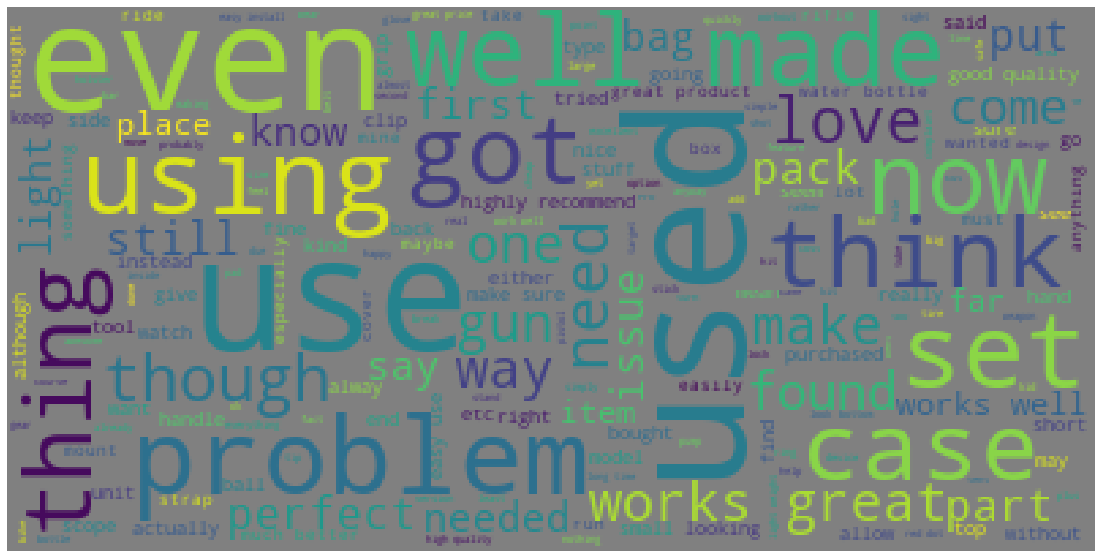

In [28]:
fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(cloud);

In [29]:
sports_outdoors[:3]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5.0,Woks very good,1390694400,2014-01-26
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5.0,Works as well as the factory tool,1328140800,2012-02-02
2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]",If you don't have a 3/32 punch or would like t...,4.0,"It's a punch, that's all.",1330387200,2012-02-28


### Insert `pos_neg` column for Sentiment modeling

         Negative reviews:      1-3 Stars  = 0
         Positive reviews:      4-5 Stars  = 1

 

In [30]:
sports_outdoors['pos_neg'] = [1 if x > 3 else 0 for x in sports_outdoors.overall]

In [31]:
sports_outdoors.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,pos_neg
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5.0,Woks very good,1390694400,2014-01-26,1
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5.0,Works as well as the factory tool,1328140800,2012-02-02,1
2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]",If you don't have a 3/32 punch or would like t...,4.0,"It's a punch, that's all.",1330387200,2012-02-28,1
3,A148SVSWKTJKU6,1881509818,"Jusitn A. Watts ""Maverick9614""","[0, 0]",This works no better than any 3/32 punch you w...,4.0,It's a punch with a Glock logo.,1328400000,2012-02-05,1
4,AAAWJ6LW9WMOO,1881509818,Material Man,"[0, 0]",I purchased this thinking maybe I need a speci...,4.0,"Ok,tool does what a regular punch does.",1366675200,2013-04-23,1


In [33]:
review_text = sports_outdoors["reviewText"]
review_text

0         This came in on time and I am veru happy with ...
1         I had a factory Glock tool that I was using fo...
2         If you don't have a 3/32 punch or would like t...
3         This works no better than any 3/32 punch you w...
4         I purchased this thinking maybe I need a speci...
                                ...                        
296332    This is a water bottle done right. It is a ver...
296333    If you're looking for an insulated water bottl...
296334    This Hydracentials Sporty 25 OZ, double insula...
296335    As usual I received this item free in exchange...
296336    Hydracentials insulated 25 oz water bottle.Thi...
Name: reviewText, Length: 296337, dtype: object

### Train/Test Split

In [34]:
x_train, x_test, y_train, y_test = train_test_split(sports_outdoors.reviewText, sports_outdoors.pos_neg, random_state=0)

In [35]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (222252,)
y_train shape: (222252,)

x_test shape: (74085,)
y_test shape: (74085,)



---
## `Logistic Regression`

### `CountVectorizer`

In [36]:
# Vectorize X_train
vectorizer = CountVectorizer(min_df=5).fit(x_train)
X_train = vectorizer.transform(x_train)
print("X_train:\n{}".format(repr(X_train)))
print(X_train)

X_train:
<222252x28733 sparse matrix of type '<class 'numpy.int64'>'
	with 12428687 stored elements in Compressed Sparse Row format>
  (0, 43)	1
  (0, 469)	1
  (0, 2385)	1
  (0, 3137)	1
  (0, 3791)	1
  (0, 3845)	1
  (0, 4865)	1
  (0, 5031)	1
  (0, 7325)	1
  (0, 7744)	1
  (0, 10273)	2
  (0, 12096)	1
  (0, 12497)	1
  (0, 13054)	1
  (0, 13700)	2
  (0, 13726)	1
  (0, 13729)	3
  (0, 14812)	1
  (0, 15337)	1
  (0, 16958)	2
  (0, 17133)	1
  (0, 17379)	1
  (0, 17814)	2
  (0, 18835)	1
  (0, 19360)	1
  :	:
  (222251, 16435)	1
  (222251, 16958)	1
  (222251, 17286)	2
  (222251, 17379)	1
  (222251, 17572)	1
  (222251, 17592)	1
  (222251, 17814)	1
  (222251, 17872)	1
  (222251, 18703)	1
  (222251, 18835)	1
  (222251, 19759)	1
  (222251, 19767)	1
  (222251, 19834)	1
  (222251, 22861)	1
  (222251, 22864)	1
  (222251, 23302)	2
  (222251, 24161)	1
  (222251, 25448)	2
  (222251, 25467)	5
  (222251, 25587)	1
  (222251, 25610)	1
  (222251, 25883)	1
  (222251, 28017)	1
  (222251, 28086)	1
  (222251, 28094)	1

In [38]:
feature_names = vectorizer.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("\n\n",feature_names)

Number of features: 28733


 ['00', '000', '0000', '0001', '0005', '001', '002', '003', '004', '005', '007', '008', '009', '00am', '00i', '00pm', '01', '010', '012', '015', '01523', '01526', '01902', '01kz', '02', '0200', '021', '025', '02a', '03', '0300', '0350', '04', '05', '0560', '06', '07', '08', '080', '09', '0f', '0l', '10', '100', '1000', '10000', '1000d', '1000fps', '1000ft', '1000ml', '1000s', '1000x', '1007', '1009', '100f', '100ft', '100g', '100k', '100km', '100lb', '100lbs', '100m', '100mm', '100mph', '100oz', '100psi', '100rds', '100s', '100th', '100x', '100yards', '100yd', '100yds', '100yrd', '100yrds', '101', '102', '1020', '1022', '103', '104', '1045', '105', '1050', '1051', '1055', '105psi', '106', '1060', '107', '1070', '1075', '1077', '108', '1080', '1085', '1088', '109', '1090', '1095', '10a', '10accuracy', '10am', '10cm', '10f', '10ft', '10g', '10i', '10inch', '10k', '10l', '10lb', '10lbs', '10looks', '10m', '10min', '10mm', '10mph', '10overall', '10oz', '10price'

---
## Logistic Regression 
### on Training data

In [19]:
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)

In [20]:
print("Mean cross-validation accuracy: {:.3f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.888


---

In [21]:
logreg = LogisticRegression(C=0.1).fit(X_train, y_train)

X_test = vectorizer.transform(x_test)#vectorize x_test

log_y_pred = logreg.predict(X_test)

In [23]:
logreg_score = accuracy_score(y_test, log_y_pred)
print("Accuracy:   {:.3f}".format(logreg_score))

Accuracy:   0.890


In [62]:
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test))) 

Training set score: 0.907
Test set score: 0.890


In [47]:
log_cfm = confusion_matrix(y_test, log_y_pred)
print("Confusion matrix:")
print(log_cfm, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[ 4645  6289]
 [ 1831 61320]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


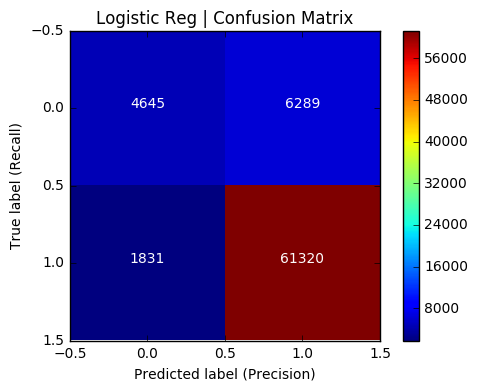

In [69]:
plt.imshow(log_cfm, interpolation='nearest')

for i, j in itertools.product(range(log_cfm.shape[0]), range(log_cfm.shape[1])):
    plt.text(j, i, log_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Reg | Confusion Matrix')
plt.colorbar();

In [73]:
log_f1 = f1_score(y_test, log_y_pred)
print("Logistic Reg - F1 score: {:.3f}".format(log_f1))

Logistic Reg - F1 score: 0.938


### GridSearchCV on $\underline{Training\ data}$ to _Increase Performance_

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

In [187]:
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.891
Best parameters:  {'C': 0.1}


### _Apply Best Parameters_ from GridSearchCV on $\underline{Testing\ data}$

In [190]:
print("{:.3f}".format(grid.score(X_test, y_test)))

0.890


In [ ]:
grid_log_f1 = f1_score(y_test, log_y_pred)
print("Grid Logistic Reg - F1 score: {:.3f}".format(grid_log_f1))

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)

---
## `TfidfVectorizer` with Pipeline through `GridSearchCV`

In [67]:
# Attempt one ... with no Test phase
pipeline = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression())
tfidf_param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

tfidf_grid = GridSearchCV(pipeline, tfidf_param_grid, cv=5)
tfidf_grid.fit(x_train, y_train)

print("Best cross-validation score: {:.3f}".format(tfidf_grid.best_score_))
print("Best parameters: ", tfidf_grid.best_params_)

Best cross-validation score: 0.892
Best parameters:  {'logisticregression__C': 0.001}


### Need Many HOURS run

In [225]:
# Code Excerpt Adapted From: “Python Machine Learning.” iBooks. pg.403-404 

# tfidf_vect = TfidfVectorizer(strip_accents=None,
#                              lowercase=False,
#                              preprocessor=None)

# tfidf_param_grid = [{'vect__ngram_range': [(1,1)],
#                       'vect__stop_words': [stops, None],
#                       'vect__tokenizer': [tokenizer2],
#                       'clf__penalty': ['l1', 'l2'],
#                       'clf__C': [1.0, 10.0, 100.0]},
#                      {'vect__ngram_range': [(1,1)],
#                       'vect__stop_words': [stops, None],
#                       'vect__tokenizer': [tokenizer2],
#                       'vect__use_idf':[False],
#                       'vect__norm':[None],
#                       'clf__penalty': ['l1', 'l2'],
#                       'clf__C': [1.0, 10.0, 100.0]}
#                     ]

# lr_tfidf = Pipeline([('vect', tfidf_vect),
#                      ('clf',
#                       LogisticRegression(random_state=0))])

# gs_lr_tfidf = GridSearchCV(lr_tfidf, tfidf_param_grid,
#                            scoring='accuracy',
#                            cv=5, verbose=1,
#                            n_jobs=-1)

# gs_lr_tfidf.fit(x_train, y_train)

---
## Multinomial Bayes 
### on Training data

## `CountVectorizer`

In [48]:
mnb = MultinomialNB(alpha=.01)
mnb.fit(X_train, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [49]:
mnb_y_pred = mnb.predict(X_test)

In [51]:
mnb_score = accuracy_score(y_test, mnb_y_pred)
print("Accuracy:   {:.3f}".format(mnb_score))

Accuracy:   0.865


In [63]:
print("Training set score: {:.3f}".format(mnb.score(X_train, y_train)))
print("Test set score: {:.3f}".format(mnb.score(X_test, y_test)))

Training set score: 0.883
Test set score: 0.865


In [58]:
mnb_cfm = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[ 5968  4966]
 [ 5009 58142]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


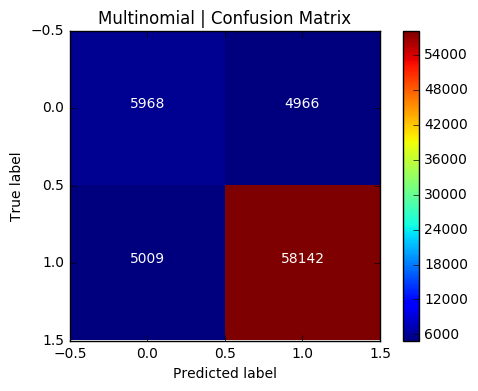

In [68]:
plt.imshow(mnb_cfm, interpolation='nearest')

for i, j in itertools.product(range(mnb_cfm.shape[0]), range(mnb_cfm.shape[1])):
    plt.text(j, i, mnb_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Multinomial | Confusion Matrix')
plt.colorbar();

In [74]:
mnb_f1 = f1_score(y_test, mnb_y_pred)
print("Multinomial NB - F1 score: {:.3f}".format(mnb_f1))

Multinomial NB - F1 score: 0.921


## `TfidfVectorizer`

In [75]:
# Vectorize X_train
mnb_tfidfvectorizer = TfidfVectorizer(min_df=5).fit(x_train)
mnb_X_train = mnb_tfidfvectorizer.transform(x_train)
print("X_train:\n{}".format(repr(mnb_X_train)))

X_train:
<222252x28733 sparse matrix of type '<class 'numpy.float64'>'
	with 12428687 stored elements in Compressed Sparse Row format>


In [77]:
mnb_X_test = mnb_tfidfvectorizer.transform(x_test)

mnb_y_pred = mnb.predict(mnb_X_test)

In [78]:
mnb_score2 = accuracy_score(y_test, mnb_y_pred)
print("Accuracy:   {:.3f}".format(mnb_score2))

Accuracy:   0.856


In [80]:
print("Training set score: {:.3f}".format(mnb.score(mnb_X_train, y_train)))
print("Test set score: {:.3f}".format(mnb.score(mnb_X_test, y_test)))

Training set score: 0.861
Test set score: 0.856


In [81]:
mnb_cfm2 = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm2, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[  312 10622]
 [   42 63109]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


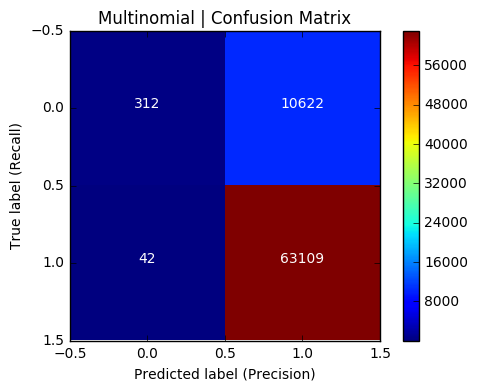

In [82]:
plt.imshow(mnb_cfm2, interpolation='nearest')

for i, j in itertools.product(range(mnb_cfm2.shape[0]), range(mnb_cfm2.shape[1])):
    plt.text(j, i, mnb_cfm2[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Multinomial | Confusion Matrix')
plt.colorbar();

In [83]:
mnb2_f1 = f1_score(y_test, mnb_y_pred)
print("Multinomial NB - F1 score: {:.3f}".format(mnb2_f1))

Multinomial NB - F1 score: 0.922


### Summary:

* Logistic with TF wins!

* Multinomial NB with Tfidf in second.
